In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

np.random.seed(42)

In [3]:
boston = fetch_openml(name='boston', version=1, as_frame=True)
X_orig = boston.data.to_numpy()
y = boston.target.to_numpy()
n, p_orig = X_orig.shape

noise_settings = [0, n, 2 * n] 
results = []
coefs = {}


c:\Users\dkkdk\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
# Loop over each noise setting
for p_noise in noise_settings:
    if p_noise > 0:
        noise = np.random.uniform(low=-1, high=1, size=(n, p_noise))
        X = np.hstack([X_orig, noise])
    else:
        X = X_orig

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

    # OLS
    ols = LinearRegression()
    ols.fit(X_train, y_train)
    y_pred_ols = ols.predict(X_test)
    mse_ols = mean_squared_error(y_test, y_pred_ols)
    coefs[("OLS", p_noise)] = ols.coef_

    # Ridge with CV
    ridge = RidgeCV(alphas=np.linspace(0.01, 150, 100))
    ridge.fit(X_train, y_train)
    y_pred_ridge = ridge.predict(X_test)
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    coefs[("Ridge", p_noise)] = ridge.coef_

    # Lasso with CV
    lasso = LassoCV(alphas=None, cv=5, max_iter=10000)
    lasso.fit(X_train, y_train)
    y_pred_lasso = lasso.predict(X_test)
    mse_lasso = mean_squared_error(y_test, y_pred_lasso)
    coefs[("Lasso", p_noise)] = lasso.coef_

    # Save results
    results.append({
        "Noise Variables": p_noise,
        "OLS MSE": mse_ols,
        "Ridge MSE": mse_ridge,
        "Lasso MSE": mse_lasso
    })

   Noise Variables     OLS MSE  Ridge MSE  Lasso MSE
0                0   14.995853  14.988733  17.355491
1              506  197.262424  29.416756  17.355491
2             1012   28.173347  17.713065  17.355491


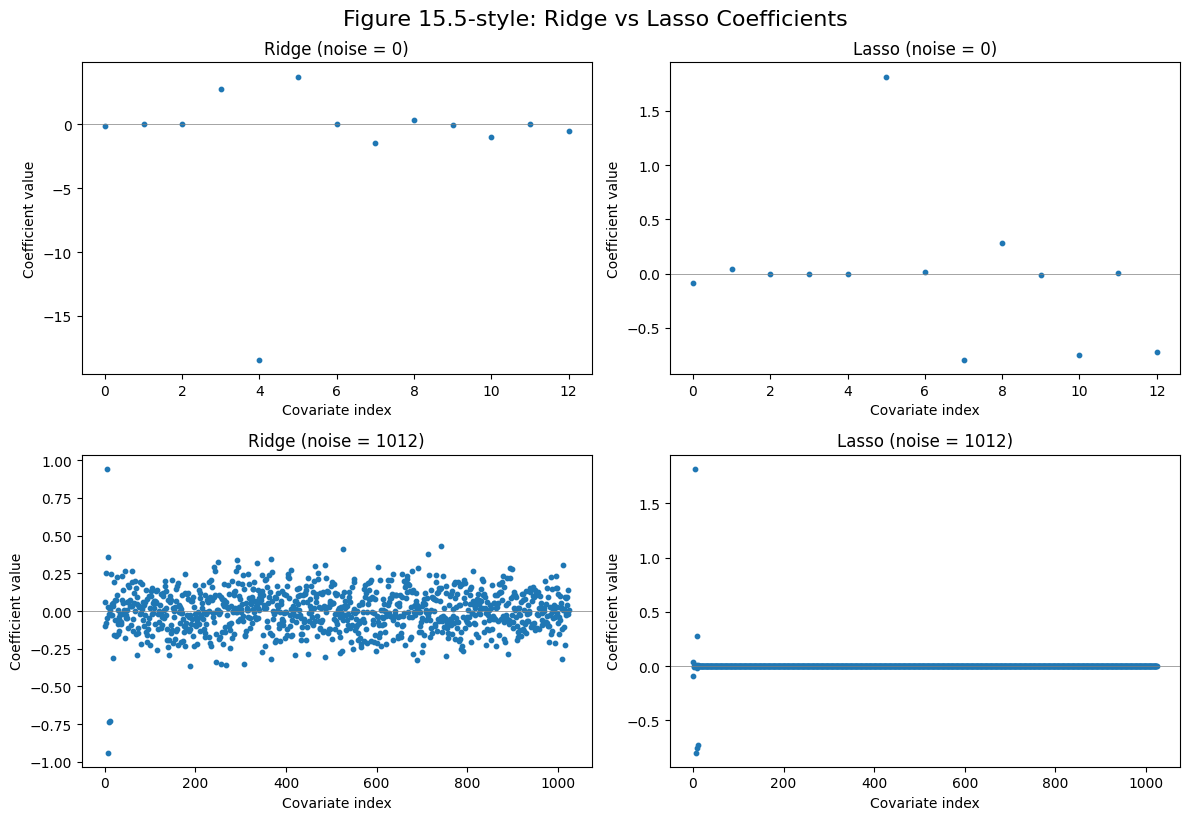

In [5]:
# Show results in table
df_results = pd.DataFrame(results)
print(df_results)

# Plot coefficients: Figure 15.5 style
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
noise_levels = [0, 2 * n]
models = ["Ridge", "Lasso"]

for row_idx, p_noise in enumerate(noise_levels):
    for col_idx, model in enumerate(models):
        ax = axes[row_idx, col_idx]
        coef = coefs[(model, p_noise)]
        ax.scatter(range(len(coef)), coef, s=10)
        ax.set_title(f"{model} (noise = {p_noise})")
        ax.set_xlabel("Covariate index")
        ax.set_ylabel("Coefficient value")
        ax.axhline(0, color='gray', linewidth=0.5)

plt.tight_layout()
plt.suptitle("Figure 15.5-style: Ridge vs Lasso Coefficients", y=1.02, fontsize=16)
plt.show()

When no noise is added, all three models perform similarly, consistent with the findings in Section 15.4.

When noise variables are introduced, OLS overfits significantly, with its MSE increasing dramatically.

Ridge and Lasso remain robust to the added noise. Ridge shrinks all coefficients slightly, while Lasso selectively sets many to exactly zero.

Lasso shows the lowest MSE in all settings, indicating strong resistance to irrelevant noise covariates — also consistent with Section 15.4.